### Exploratory Data Analysis (Receipts OCR)
Data source example: https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/

This notebook performs a practical EDA for an AI program that reads receipt information (OCR + field extraction).
It covers: inventory, image quality, layout diversity, (optional) labels profiling, baseline OCR probe, field extraction probes, error metrics, leakage-safe splits, and visual reports.


## 0) Setup & Configuration
- Adjust paths to match your dataset.
- Optional dependencies (pytesseract, scikit-learn, jiwer) are guarded with try/except. Install if needed.
- The notebook aims to run even if some optional packages are missing; those sections will be skipped with a message.


In [1]:
from pathlib import Path
import os, json, hashlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Default dataset layout in this repo
IMG_DIR = Path('train_data/images')
LABELS_CSV = Path('train_data/gdt')

print('Images:', IMG_DIR.resolve())
print('Labels CSV:', LABELS_CSV.resolve())


Images: /Users/Ian/Workshop/LIVE-AI_Best-Coast/train_data/images
Labels CSV: /Users/Ian/Workshop/LIVE-AI_Best-Coast/train_data/gdt


## 1) Inventory and Metadata
- Count images, formats, sizes, aspect ratios.
- Detect duplicates (md5) and corrupted files.


In [2]:
def file_hash(p: Path):
    h = hashlib.md5()
    with open(p, 'rb') as f: h.update(f.read())
    return h.hexdigest()

rows = []
image_paths = []
if IMG_DIR.exists():
    for root, _, files in os.walk(IMG_DIR):
        for fn in files:
            fp = Path(root) / fn
            if not (fn.lower().endswith('.jpg') or fn.lower().endswith('.jpeg') or fn.lower().endswith('.png') or fn.lower().endswith('.tif') or fn.lower().endswith('.tiff')):
                continue
            try:
                with Image.open(fp) as im:
                    rows.append({
                        'path': str(fp),
                        'format': im.format,
                        'mode': im.mode,
                        'width': im.width,
                        'height': im.height,
                        'aspect': (im.width / im.height) if im.height else None,
                        'hash': file_hash(fp)
                    })
                    image_paths.append(str(fp))
            except Exception as e:
                rows.append({'path': str(fp), 'error': str(e)})
else:
    print('IMG_DIR does not exist:', IMG_DIR)

img_df = pd.DataFrame(rows)
print('Total files scanned:', len(rows))
if not img_df.empty:
    print('Corrupted/Errors:', img_df['error'].notna().sum() if 'error' in img_df else 0)
    if 'hash' in img_df:
        nunique = img_df['hash'].nunique()
        print('Duplicates by MD5:', len(img_df) - nunique)
img_df.head()


Total files scanned: 967
Corrupted/Errors: 0
Duplicates by MD5: 15


path format mode  width  height    aspect  \
0  train_data/images/823.jpg   JPEG  RGB    623    1471  0.423521   
1  train_data/images/189.jpg   JPEG  RGB   1654    2338  0.707442   
2  train_data/images/837.jpg   JPEG  RGB    615    1479  0.415822   
3  train_data/images/638.jpg   JPEG  RGB   4961    7016  0.707098   
4  train_data/images/604.jpg   JPEG  RGB    708    1699  0.416716   

                               hash  
0  fd6a6a6fab21be24450804bb0eccdcdc  
1  6f024a44f3fe3f035510dad1a1e6315f  
2  89a1fc16d3ec30d57335160afc3483e8  
3  556a2984a8881917121f05049713344d  
4  92dfc6de98f79d1dad2bc820a2ae7b62

In [3]:
img_df.sort_index()

path format mode  width  height    aspect  \
0    train_data/images/823.jpg   JPEG  RGB    623    1471  0.423521   
1    train_data/images/189.jpg   JPEG  RGB   1654    2338  0.707442   
2    train_data/images/837.jpg   JPEG  RGB    615    1479  0.415822   
3    train_data/images/638.jpg   JPEG  RGB   4961    7016  0.707098   
4    train_data/images/604.jpg   JPEG  RGB    708    1699  0.416716   
..                         ...    ...  ...    ...     ...       ...   
962  train_data/images/621.jpg   JPEG  RGB    707    1230  0.574797   
963  train_data/images/812.jpg   JPEG  RGB    623    1515  0.411221   
964  train_data/images/806.jpg   JPEG  RGB   4961    7016  0.707098   
965  train_data/images/190.jpg   JPEG  RGB    443     959  0.461940   
966  train_data/images/184.jpg   JPEG  RGB   4961    7016  0.707098   

                                 hash  
0    fd6a6a6fab21be24450804bb0eccdcdc  
1    6f024a44f3fe3f035510dad1a1e6315f  
2    89a1fc16d3ec30d57335160afc3483e8  
3    556a2984a8881917121f05049713344d  
4    92dfc6de98f79d1dad2bc820a2ae7b62  
..                                ...  
962  0c99283d892320872de2d26b249f242b  
963  f54b77d443116aa5eea4e88586a18167  
964  2d10f7567d16f029e6c6574eb5245c7c  
965  0f159b4e486c5bb5aa7cfe11df9e9d10  
966  cf1b27d4923df9eacf36313e99d92441  

[967 rows x 7 columns]

## 2) Image Quality Diagnostics
- Blur (Laplacian variance) --> measures how sharp edges are
- Brightness and contrast.
- Skew angle estimate (rough) --> measures how tilted the receipt is
- Histograms to inspect distributions.


In [4]:
import numpy as np

import cv2
def _read_gray(img):
    # robust read supporting non-ASCII paths
    data = np.fromfile(img, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

def blur_score(file_path):
    img = _read_gray(file_path)
    if img is None: return np.nan
    return float(cv2.Laplacian(img, cv2.CV_64F).var())

def brightness_contrast(file_path):
    img = _read_gray(file_path)
    if img is None: return (np.nan, np.nan)
    return float(np.mean(img)), float(np.std(img))

def estimate_skew(file_path):
    img = _read_gray(file_path)
    if img is None:
        return np.nan

    # 1. Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5,5), 0)

    # 2. Detect edges
    edges = cv2.Canny(blurred, 50, 150)

    # 3. Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0

    # 4. Take the largest contour (assume it's the receipt)
    largest_contour = max(contours, key=cv2.contourArea)

    # 5. Fit a rotated rectangle around the contour
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]  # angle of rotation

    # 6. Normalize angle to [-45, 45]
    if angle < -45:
        angle += 90

    return float(angle)

In [5]:
img_df['blur'] = img_df['path'].apply(blur_score)
img_df[['brightness','contrast']] = img_df['path'].apply(lambda p: pd.Series(brightness_contrast(p)))
img_df['skew_deg'] = img_df['path'].apply(estimate_skew)
img_df = img_df.dropna(axis=0, how="any")

Corrupt JPEG data: 33 extraneous bytes before marker 0xd9
Corrupt JPEG data: 33 extraneous bytes before marker 0xd9
Corrupt JPEG data: 33 extraneous bytes before marker 0xd9


#### Image Quality Analysis
Let us plot and explore the extremes of the following metrics: aspect ratio, width, blur (Laplacian variance), brightness (mean), contrast (std), and skew (deg).

In [6]:
# Helper utilities to visualize metric distributions and extremes
import math

def plot_metric_and_extremes(df, col, bins=30, color='steelblue', xlabel=None, title=None):
    if df is None or df.empty or col not in df.columns:
        print(f'Skipping {col}: missing or empty.')
        return
    # Histogram
    sns.histplot(df[col].dropna(), color=color, bins=bins)
    plt.title(title or col)
    plt.xlabel(xlabel or col)
    plt.ylabel('Count')
    plt.show()
    # Summary
    print(df[col].describe())
    # Extremes tables
    smallest = df.nsmallest(5, col)[['path', col]]
    largest = df.nlargest(5, col)[['path', col]]
    print(f"\n5 smallest {col}:")
    print(smallest)
    print(f"\n5 largest {col}:")
    print(largest)
    # Image grids
    def show_rows(rows, suptitle):
        if rows.empty:
            print('No rows to display')
            return
        n = len(rows)
        fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
        if n == 1:
            axes = [axes]
        for ax, (_, r) in zip(axes, rows.iterrows()):
            img = _read_gray(r['path'])
            if img is not None:
                ax.imshow(img, cmap='gray')
            ax.set_title(f"{r[col]:.2f}")
            ax.axis('off')
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()
    show_rows(smallest, f"Top 5 Smallest {col}")
    show_rows(largest, f"Top 5 Largest {col}")


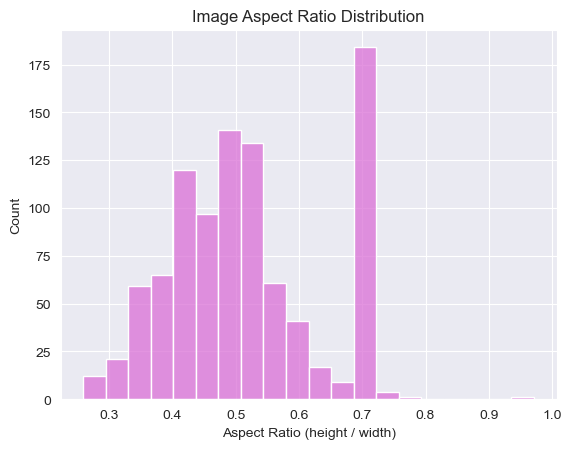

count    967.000000
mean       0.516096
std        0.120084
min        0.258861
25%        0.424166
50%        0.501425
75%        0.590056
max        0.971354
Name: aspect, dtype: float64

5 smallest aspect:
                          path    aspect
163  train_data/images/167.jpg  0.258861
460  train_data/images/450.jpg  0.263498
477  train_data/images/040.jpg  0.265834
621  train_data/images/537.jpg  0.272130
676  train_data/images/723.jpg  0.281780

5 largest aspect:
                          path    aspect
882  train_data/images/568.jpg  0.971354
919  train_data/images/350.jpg  0.765289
401  train_data/images/272.jpg  0.739324
130  train_data/images/776.jpg  0.724473
620  train_data/images/279.jpg  0.724369


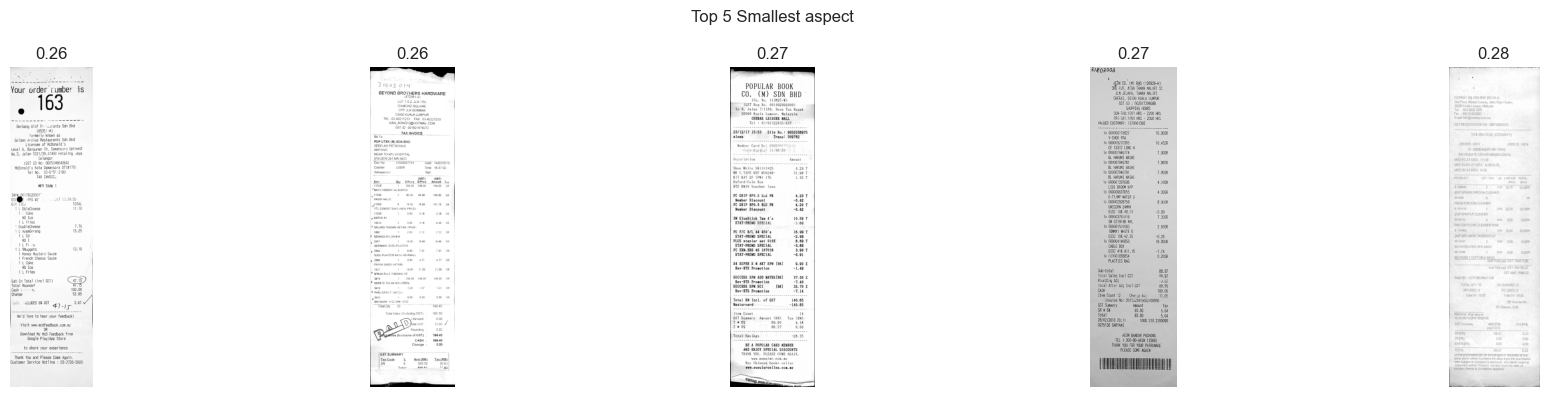

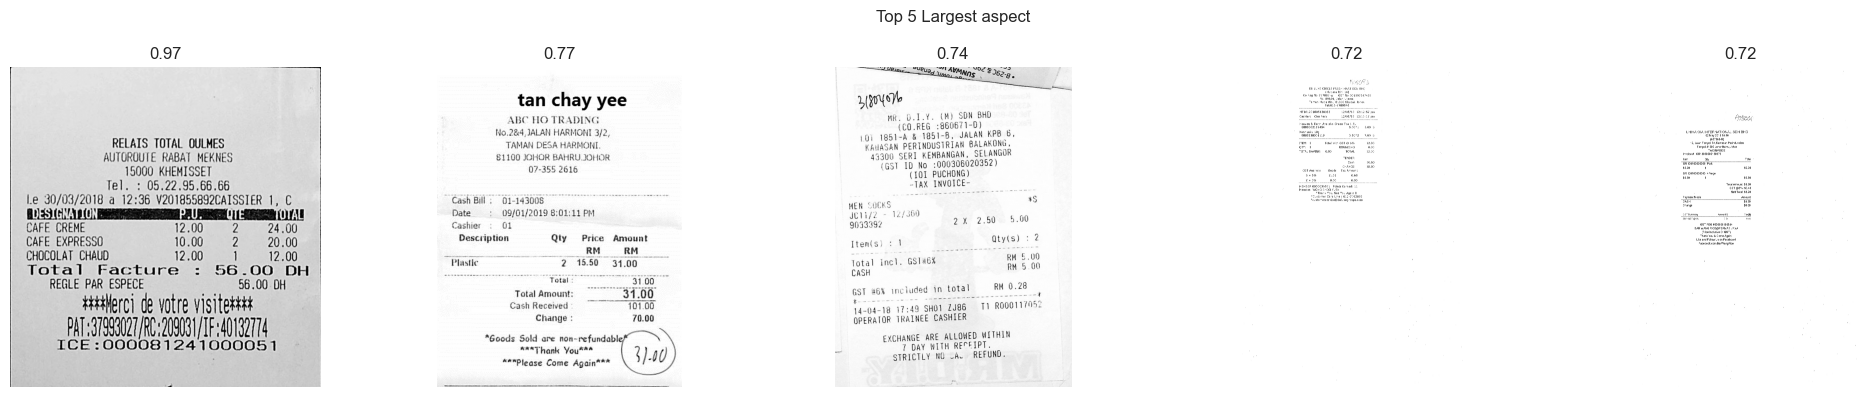

In [7]:
# 2a. Aspect Ratio
plot_metric_and_extremes(img_df, 'aspect', bins=20, color='orchid', xlabel='Aspect Ratio (height / width)', title='Image Aspect Ratio Distribution')

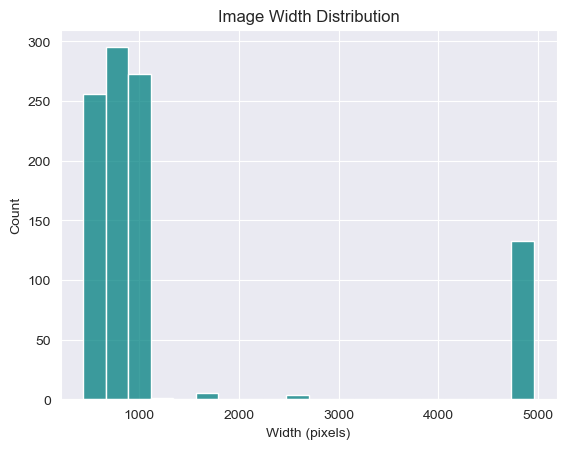

count     967.000000
mean     1362.669080
std      1448.438081
min       435.000000
25%       626.000000
50%       818.000000
75%       935.000000
max      4961.000000
Name: width, dtype: float64

5 smallest width:
                          path  width
907  train_data/images/191.jpg    435
25   train_data/images/764.jpg    436
238  train_data/images/075.jpg    439
244  train_data/images/074.jpg    439
438  train_data/images/663.jpg    439

5 largest width:
                         path  width
3   train_data/images/638.jpg   4961
22  train_data/images/770.jpg   4961
28  train_data/images/771.jpg   4961
44  train_data/images/177.jpg   4961
48  train_data/images/639.jpg   4961


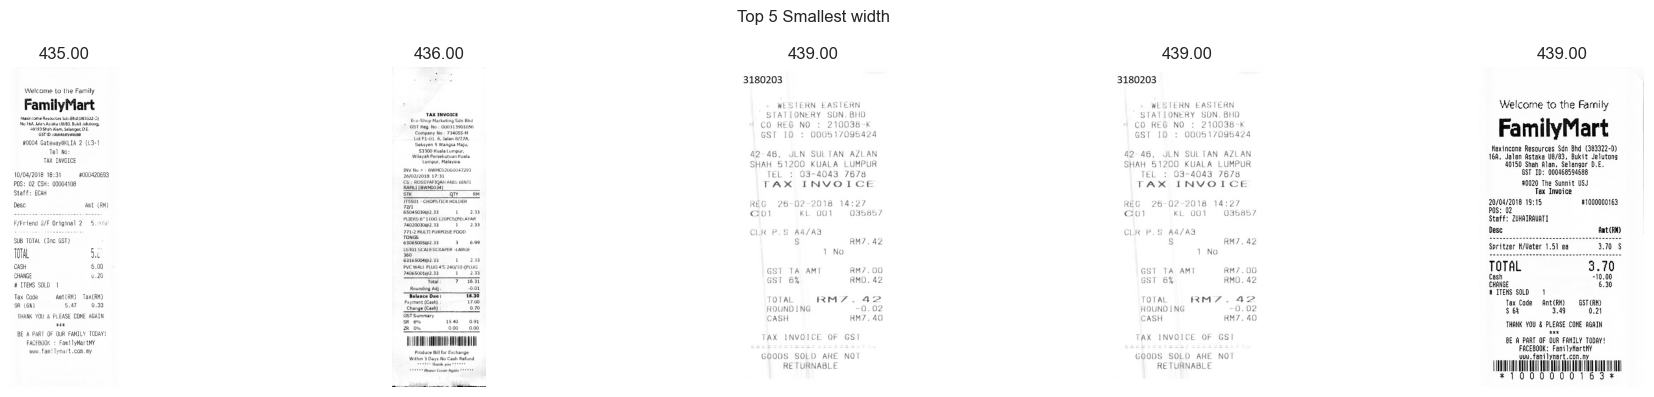

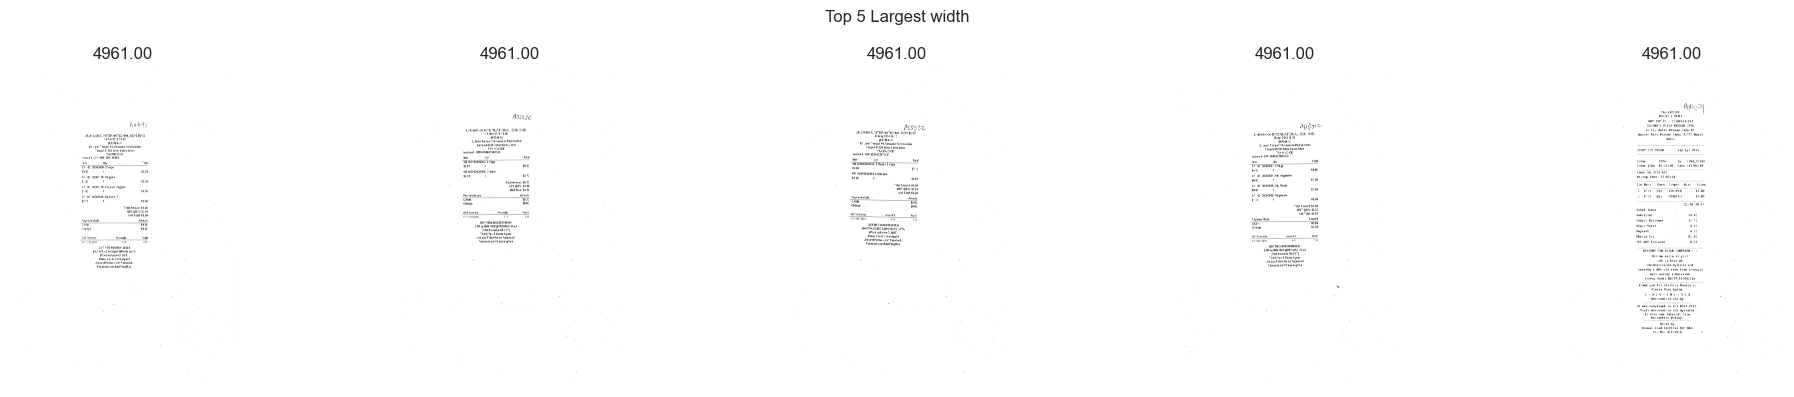

In [8]:
# 2b. Width
plot_metric_and_extremes(img_df, 'width', bins=20, color='teal', xlabel='Width (pixels)', title='Image Width Distribution')


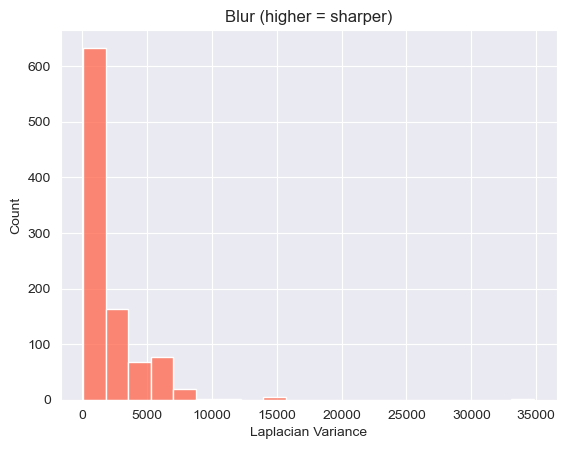

count      967.000000
mean      1973.459316
std       2387.994266
min         58.566787
25%        421.093760
50%       1240.951541
75%       2447.046180
max      34832.423230
Name: blur, dtype: float64

5 smallest blur:
                          path       blur
355  train_data/images/729.jpg  58.566787
295  train_data/images/738.jpg  63.098566
600  train_data/images/250.jpg  71.370147
681  train_data/images/736.jpg  90.388743
809  train_data/images/747.jpg  94.289973

5 largest blur:
                          path          blur
23   train_data/images/016.jpg  34832.423230
318  train_data/images/498.jpg  15334.985990
116  train_data/images/372.jpg  14407.002832
655  train_data/images/496.jpg  14346.439454
700  train_data/images/497.jpg  14170.881040


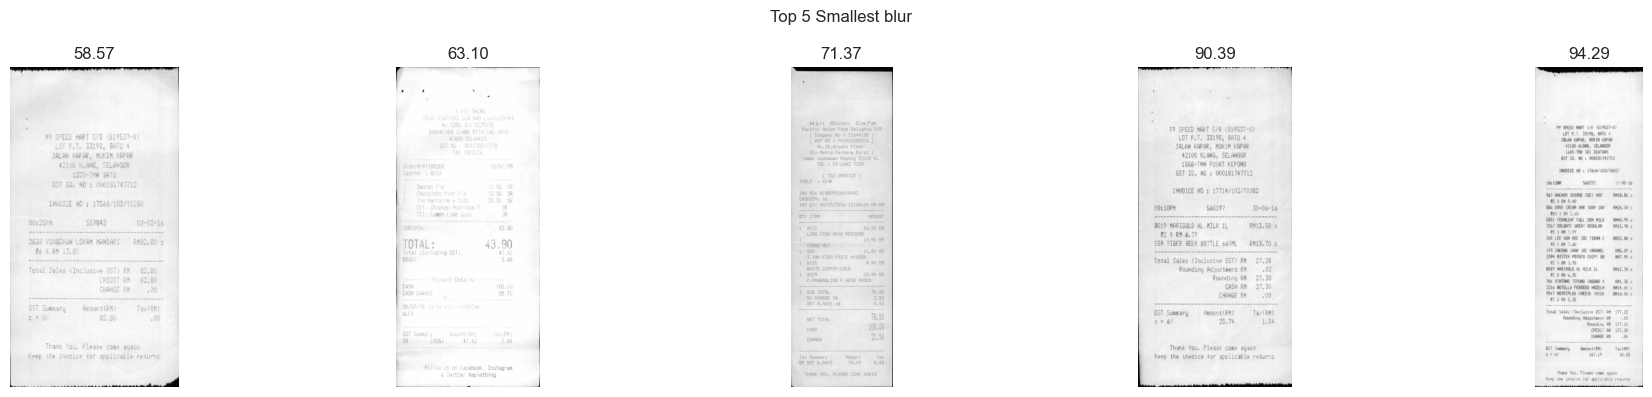

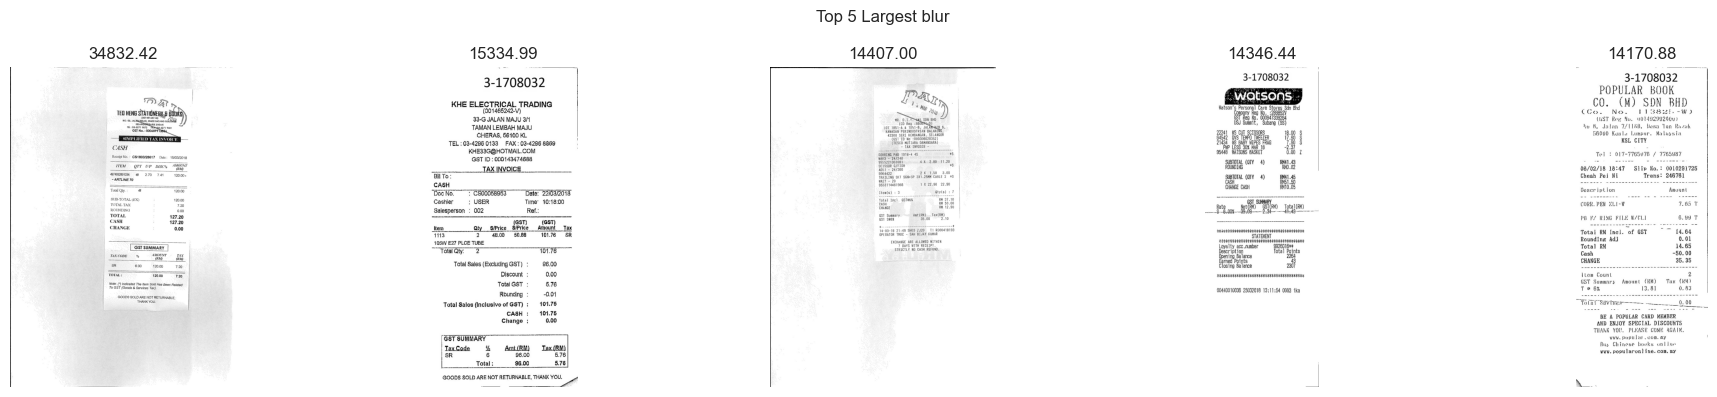

In [9]:
# 2c. Blur (Laplacian variance)
plot_metric_and_extremes(img_df, 'blur', bins=20, color='tomato', xlabel='Laplacian Variance', title='Blur (higher = sharper)')


In [10]:
def find_images_near_blur(df, target_blur, tol):
    filtered = df[df['blur'].between(target_blur - tol, target_blur + tol)].copy()
    filtered = filtered.assign(dist=(filtered['blur'] - target_blur).abs()).sort_values('dist')

    rows = filtered.head()
    n = len(rows)

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]

    # Plot images
    for ax, (_, r) in zip(axes, rows.iterrows()):
        img = _read_gray(r['path'])
        if img is not None:
            ax.imshow(img, cmap='gray')
        ax.set_title(f"{r['blur']:.1f}")
        ax.axis('off')

    plt.suptitle(f'Images near blur {target_blur} ± {tol}')
    plt.tight_layout()
    plt.show()

    return filtered

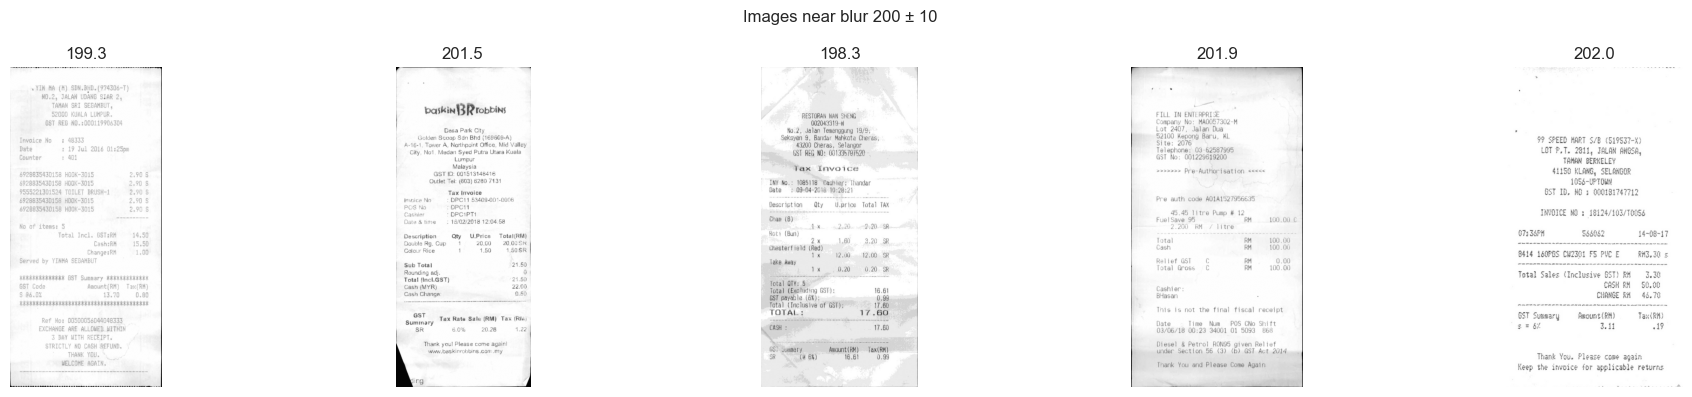

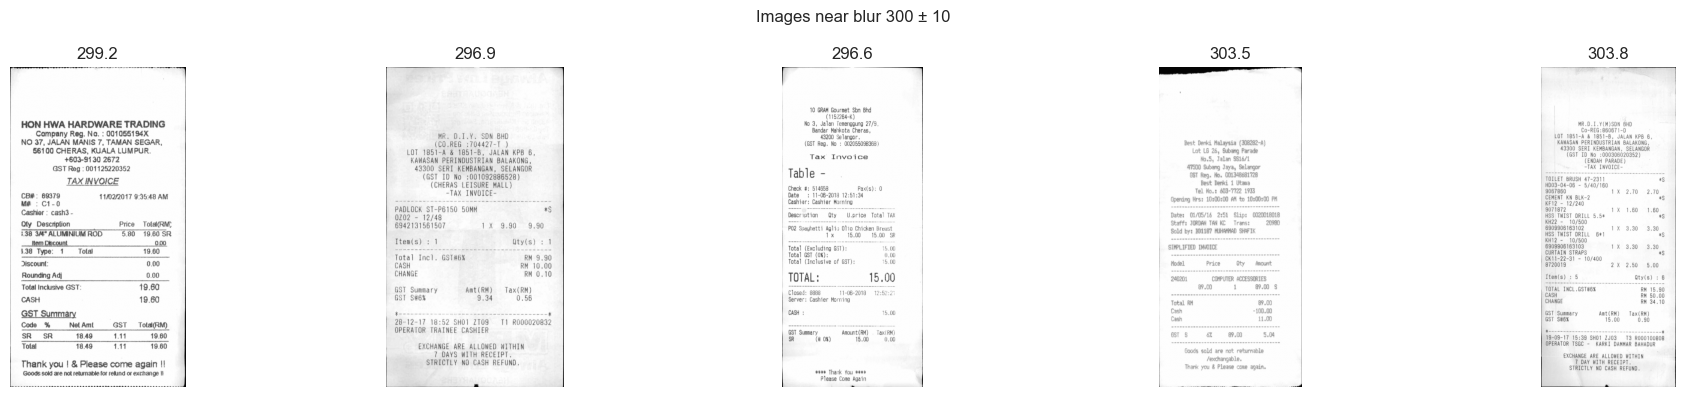

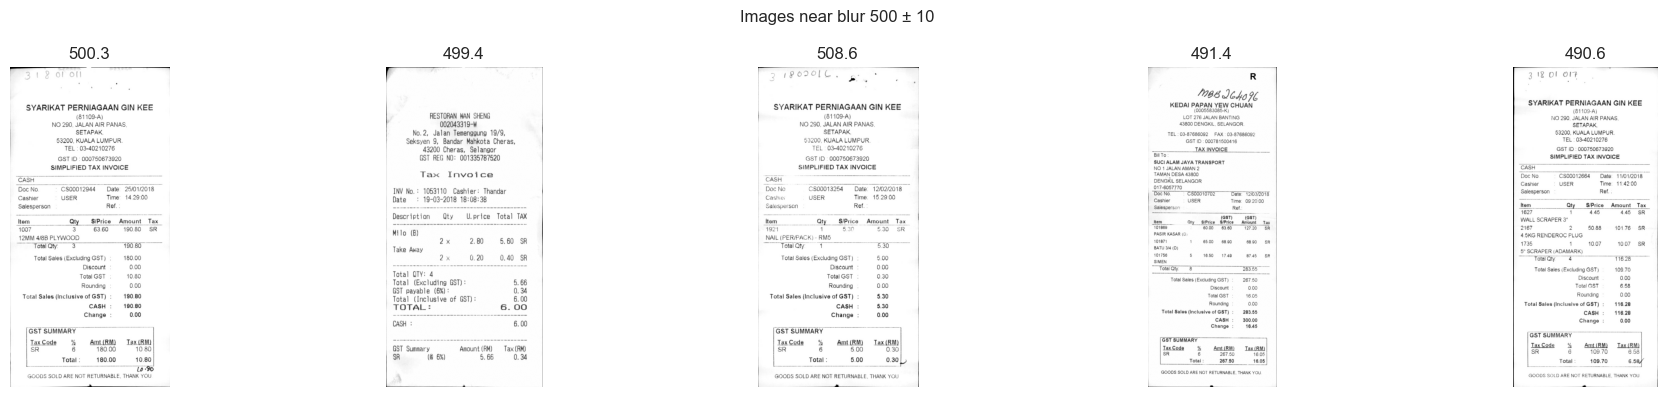

In [11]:
blur_near200 = find_images_near_blur(img_df, target_blur=200, tol=10)
blur_near300 = find_images_near_blur(img_df, target_blur=300, tol=10)
blur_near500 = find_images_near_blur(img_df, target_blur=500, tol=10)

In [12]:
img_df[ img_df['blur'] < 300 ].shape[0] / img_df.shape[0]

0.14270941054808686

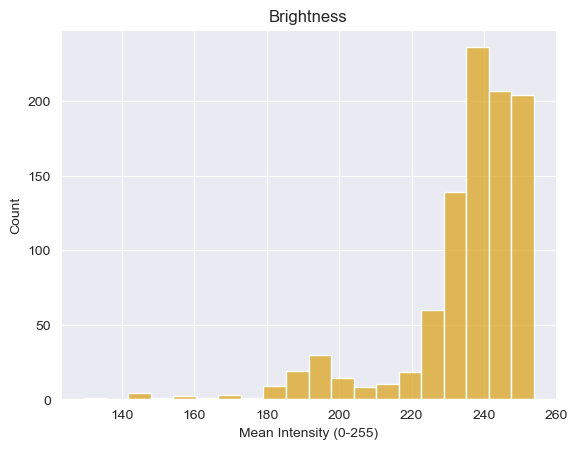

count    967.000000
mean     235.446864
std       17.935420
min      129.269415
25%      232.333806
50%      239.426648
75%      246.079608
max      253.836717
Name: brightness, dtype: float64

5 smallest brightness:
                          path  brightness
252  train_data/images/510.jpg  129.269415
863  train_data/images/569.jpg  142.733319
16   train_data/images/572.jpg  144.342084
69   train_data/images/571.jpg  144.516768
768  train_data/images/142.jpg  146.919035

5 largest brightness:
                          path  brightness
956  train_data/images/392.jpg  253.836717
900  train_data/images/636.jpg  253.718854
738  train_data/images/779.jpg  253.561398
92   train_data/images/404.jpg  253.502935
875  train_data/images/030.jpg  253.467127


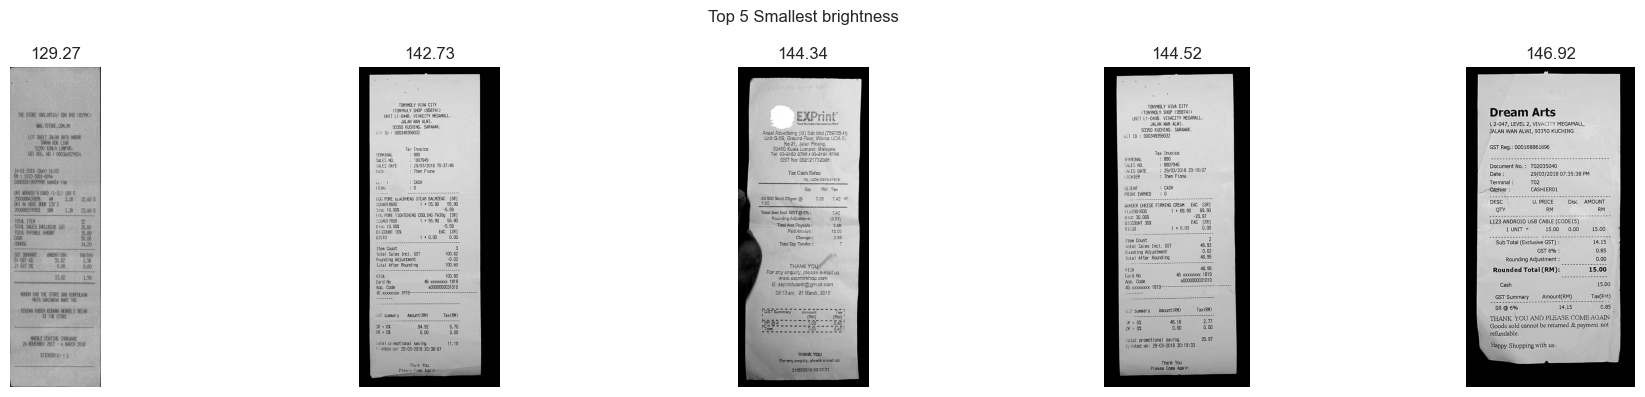

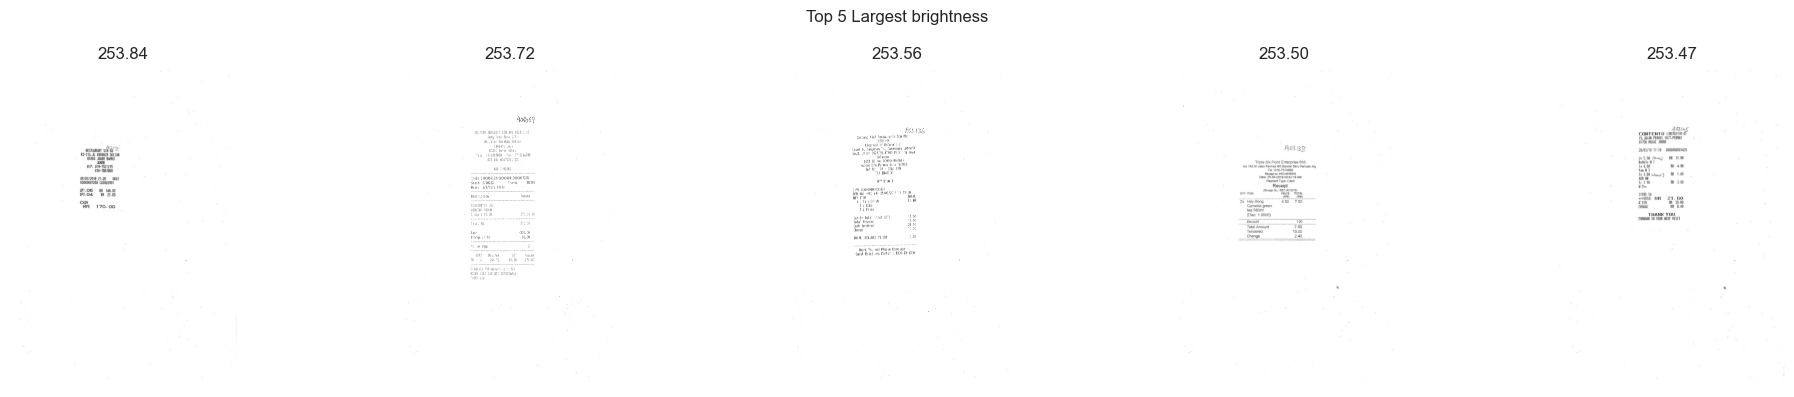

In [13]:
# 2d. Brightness
plot_metric_and_extremes(img_df, 'brightness', bins=20, color='goldenrod', xlabel='Mean Intensity (0-255)', title='Brightness')


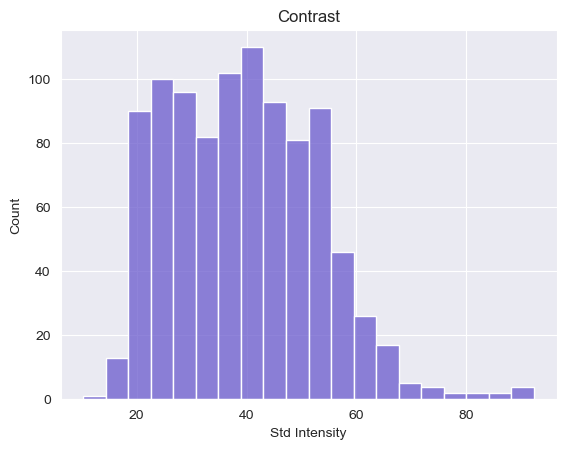

count    967.000000
mean      39.477445
std       13.397231
min       10.255632
25%       28.312080
50%       38.970817
75%       48.662946
max       92.303313
Name: contrast, dtype: float64

5 smallest contrast:
                          path   contrast
645  train_data/images/858.jpg  10.255632
786  train_data/images/418.jpg  14.520653
878  train_data/images/965.jpg  14.520653
851  train_data/images/384.jpg  15.079676
956  train_data/images/392.jpg  15.678270

5 largest contrast:
                          path   contrast
863  train_data/images/569.jpg  92.303313
768  train_data/images/142.jpg  91.301328
69   train_data/images/571.jpg  91.209229
718  train_data/images/143.jpg  89.620984
749  train_data/images/793.jpg  84.956260


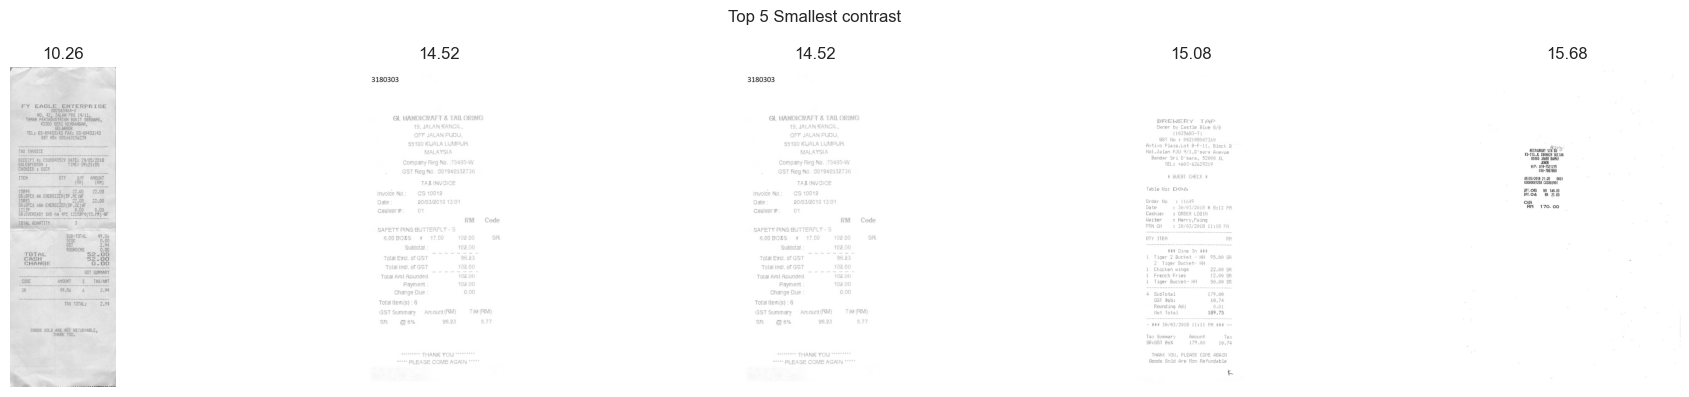

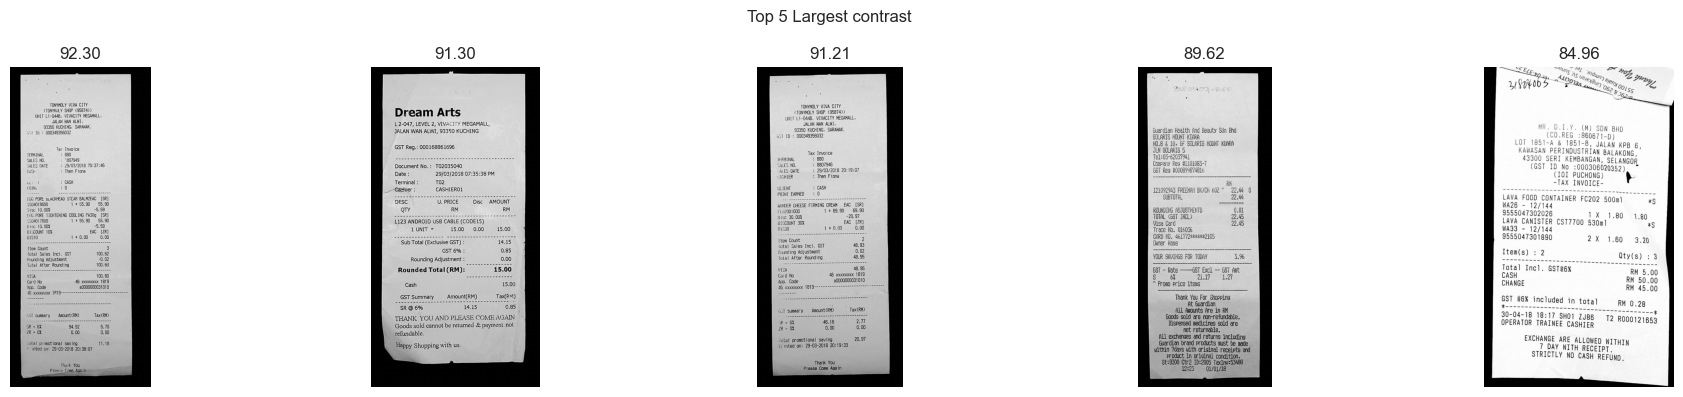

In [14]:
# 2e. Contrast
plot_metric_and_extremes(img_df, 'contrast', bins=20, color='slateblue', xlabel='Std Intensity', title='Contrast')


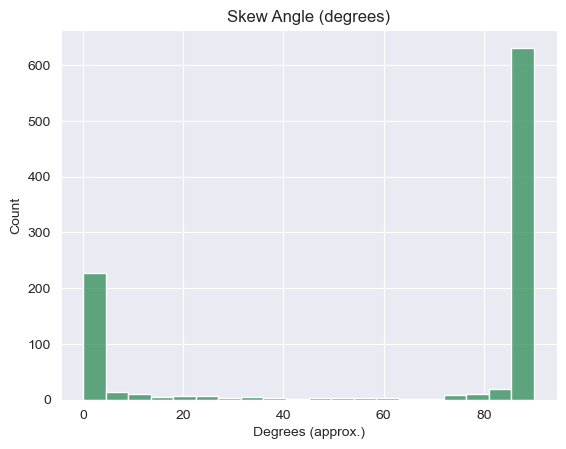

count    967.000000
mean      63.888805
std       38.931000
min        0.000000
25%        9.234281
50%       90.000000
75%       90.000000
max       90.000000
Name: skew_deg, dtype: float64

5 smallest skew_deg:
                         path  skew_deg
43  train_data/images/349.jpg       0.0
54  train_data/images/808.jpg       0.0
73  train_data/images/954.jpg       0.0
94  train_data/images/376.jpg      -0.0
95  train_data/images/410.jpg       0.0

5 largest skew_deg:
                         path  skew_deg
0   train_data/images/823.jpg      90.0
1   train_data/images/189.jpg      90.0
2   train_data/images/837.jpg      90.0
11  train_data/images/412.jpg      90.0
12  train_data/images/374.jpg      90.0


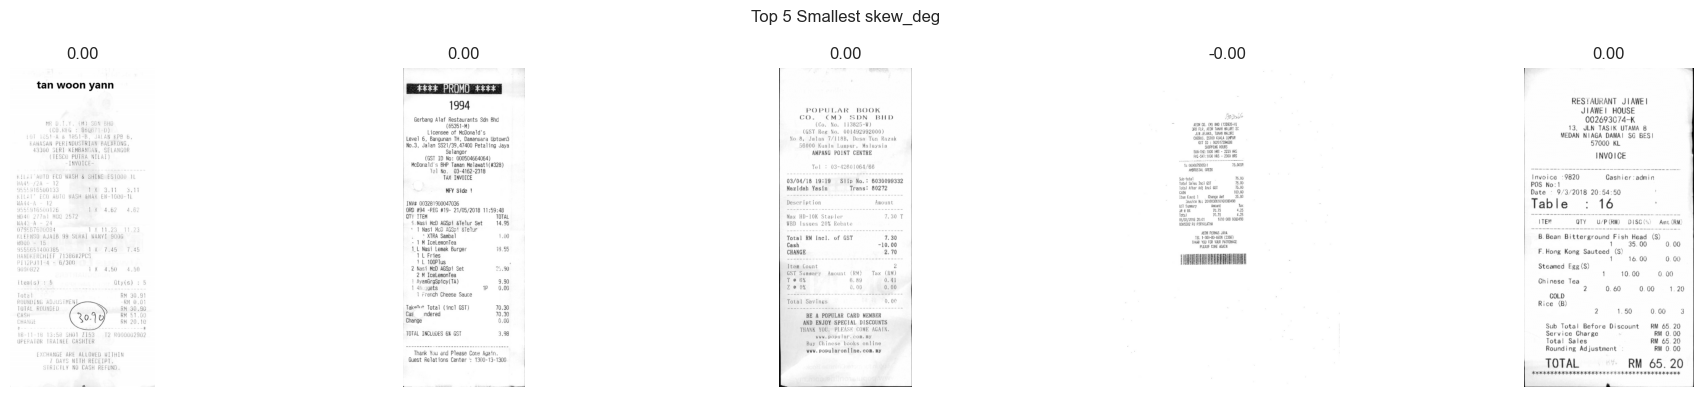

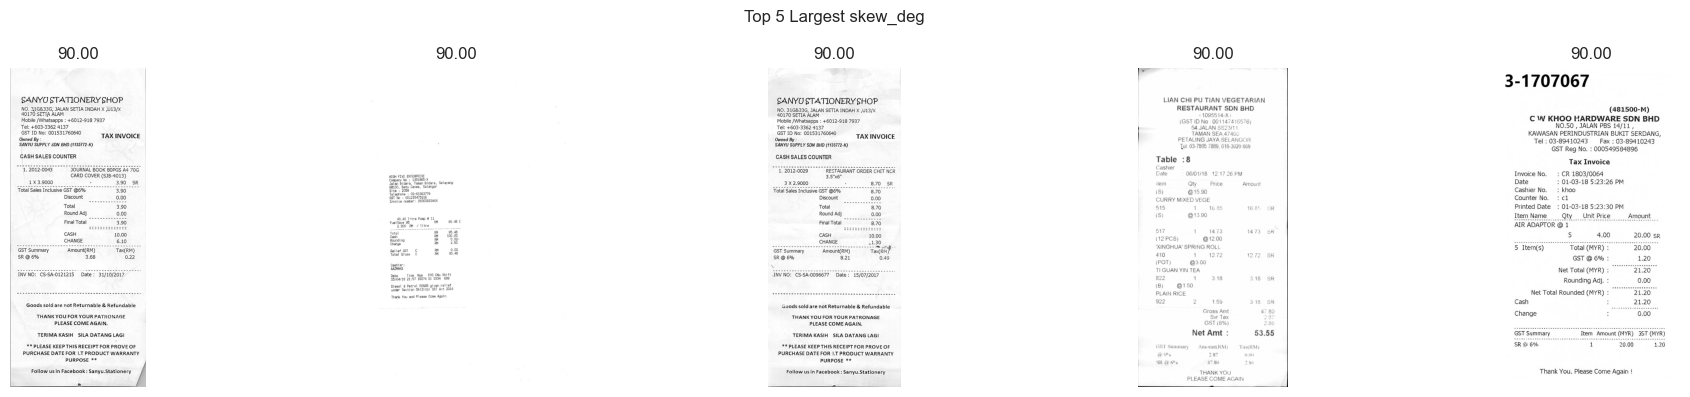

In [15]:
# 2f. Skew (degrees)
plot_metric_and_extremes(img_df, 'skew_deg', bins=20, color='seagreen', xlabel='Degrees (approx.)', title='Skew Angle (degrees)')


-

In [16]:
# 2f.i) Look specifically for near ±45° skew
# The distribution extremes did not surface clear ±45° examples. The following helper searches explicitly for images whose estimated skew angle is close to +45° or -45°.
def find_images_near_angle(df, angle, tol):
    filtered = df[df['skew_deg'].between(angle - tol, angle + tol)].copy()
    filtered = filtered.assign(dist=(filtered['skew_deg'] - angle).abs()).sort_values('dist')
    rows = filtered.head()
    n = len(rows)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    for ax, (_, r) in zip(axes, rows.iterrows()):
        img = _read_gray(r['path'])
        if img is not None:
            ax.imshow(img, cmap='gray')
        ax.set_title(f"{r['skew_deg']:.1f}°")
        ax.axis('off')
    plt.suptitle(f'Images near {angle}° (±{tol}°)')
    plt.tight_layout()
    plt.show()
    return filtered


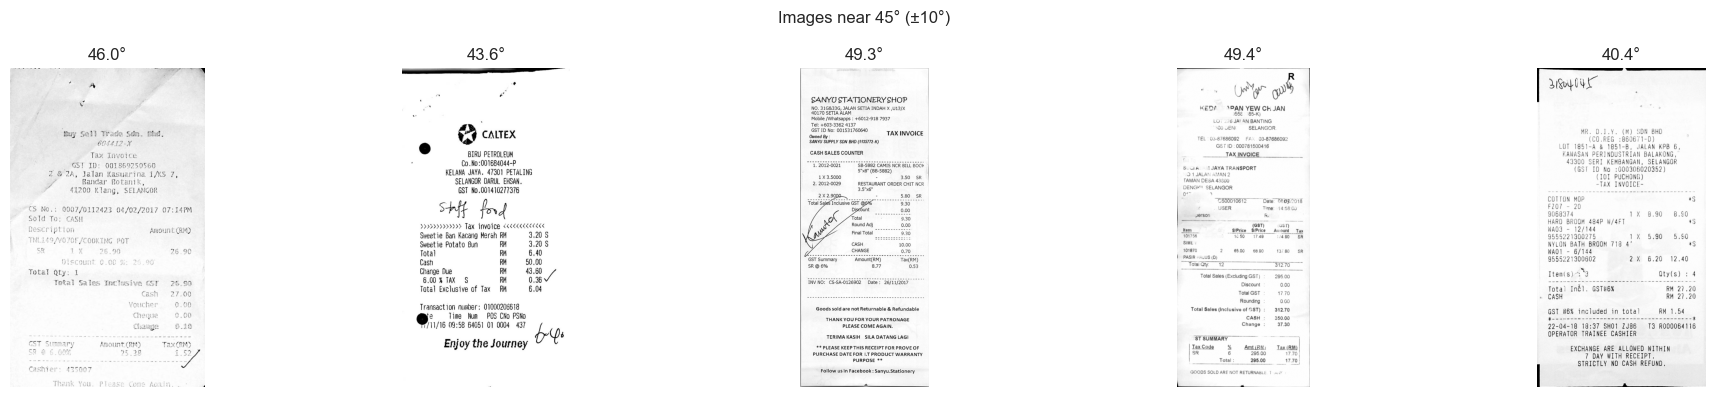

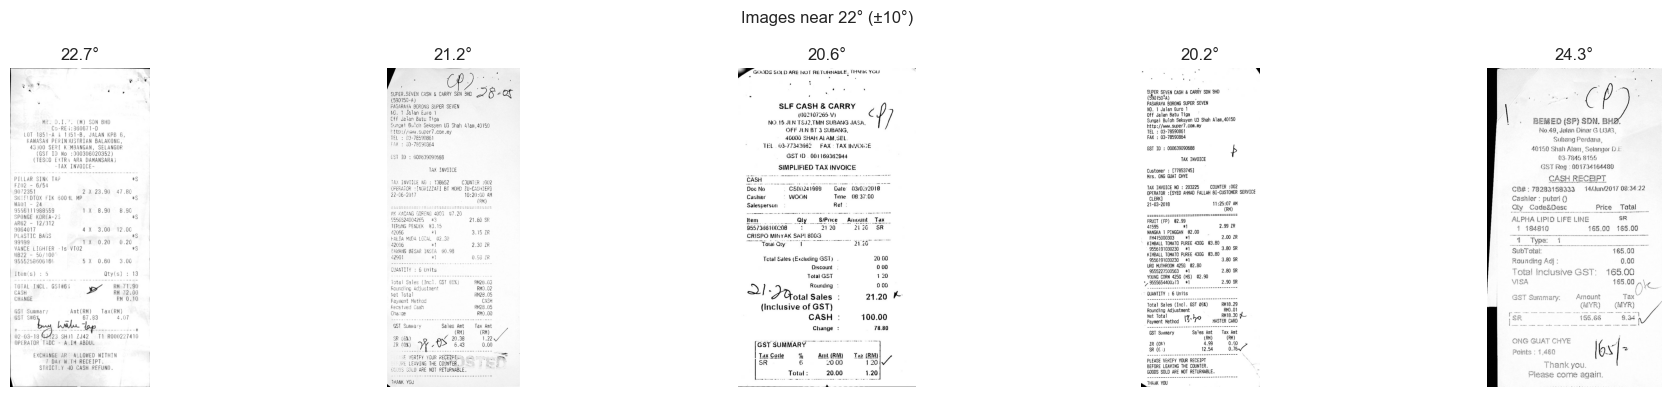

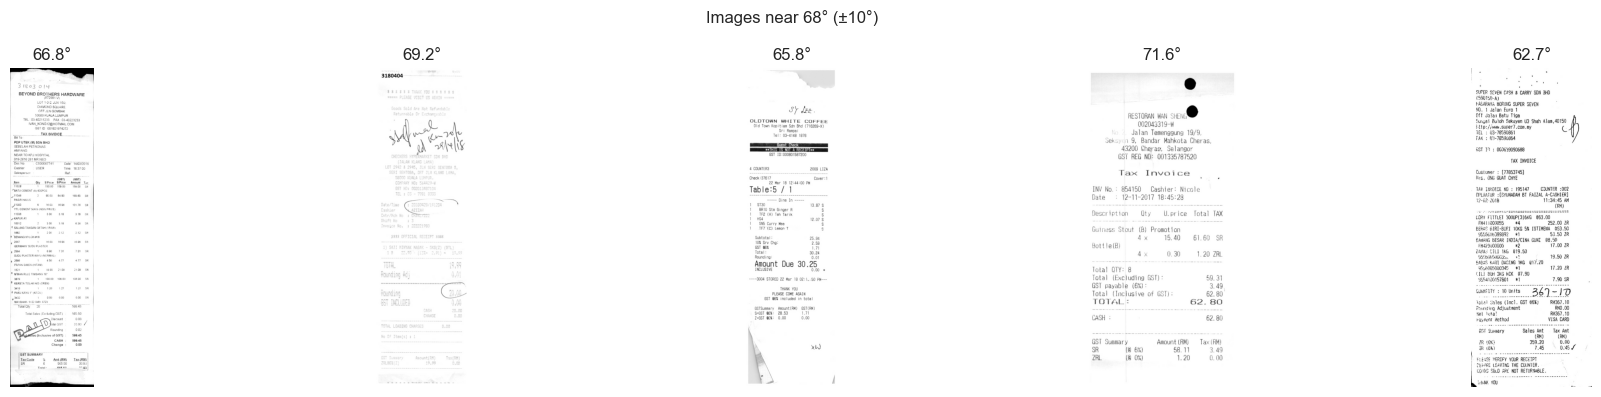

In [17]:
near_45 = find_images_near_angle(img_df, angle=45, tol=10)
near_22 = find_images_near_angle(img_df, angle=22, tol=10)
near_68 = find_images_near_angle(img_df, angle=68, tol=10)

### Takeaways
- Aspect ratios are approximately normally distributed around 0.5, but has a massive spike at 0.7
    - It is possible that receipts are defaulted to an aspect ratio of 0.7 at many establishments. If this is true, maybe receipts with length that scales with the amount of text on them are normally distributed.
    - It is also possible that many images are taken with phone cameras with little or no cropping. Most phone cameras take pictures at 4:3, or an aspect ratio of 3/4 = 0.75
- Blur has a wide spread, but very low blurs are very concerning
    - Low blur scores (< 300) may be difficult or impossible to read.
        - This may call for a contrast boost or discarding these images
        - Accounts for ~14% of the data
    - There is little difference between blur scores of 500 and 5000
- Brightness and contrast upper extremes reveal the impact of backgrounds on the images.
- Skew does not tell much about the image
    - ~0 and ~90 are correctly oriented reciepts
    - In-between, non-square angles highlight creases and handwritten text, but the receipts remain upright

## 3) PCA dimensionality reduction


In [18]:
try:
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    feats, paths = [], []
    for p in img_df.get('path', []) if 'path' in img_df else []:
        try:
            im = Image.open(p).convert('L').resize((64, 64))
            feats.append(np.array(im).flatten()/255.0)
            paths.append(p)
        except Exception:
            pass
    if feats:
        X = np.stack(feats)
        n_comp = int(min(32, X.shape[0], X.shape[1])) if X.ndim == 2 else 8
        n_comp = max(2, n_comp)
        pca = PCA(n_components=n_comp).fit_transform(X)
        n_clusters = min(8, max(1, len(paths)//20) or 1)
        km = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(pca)
        clusters = pd.DataFrame({'path': paths, 'cluster': km.labels_})
        print(clusters['cluster'].value_counts())
    else:
        clusters = pd.DataFrame(columns=['path','cluster'])
        print('No features computed; skipping clustering')
except ModuleNotFoundError:
    clusters = pd.DataFrame(columns=['path','cluster'])
    print('scikit-learn not installed; skipping clustering. Install with: pip install scikit-learn')


cluster
4    313
2    244
0    161
1     84
7     58
3     57
5     39
6     11
Name: count, dtype: int64


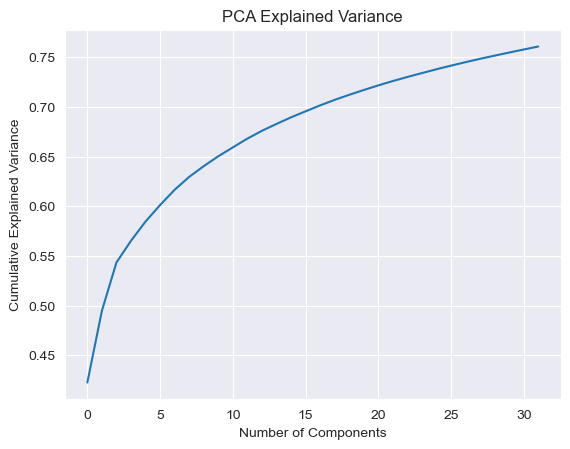

In [19]:
pca = PCA(n_components=n_comp).fit_transform(X)
pca_model = PCA(n_components=n_comp)
X_pca = pca_model.fit_transform(X)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

### Feature contribution barplots for top 5 PCs (engineered metrics)
Bar plots of absolute PCA loadings for named feature columns (e.g., 'contrast'), using the engineered metrics.

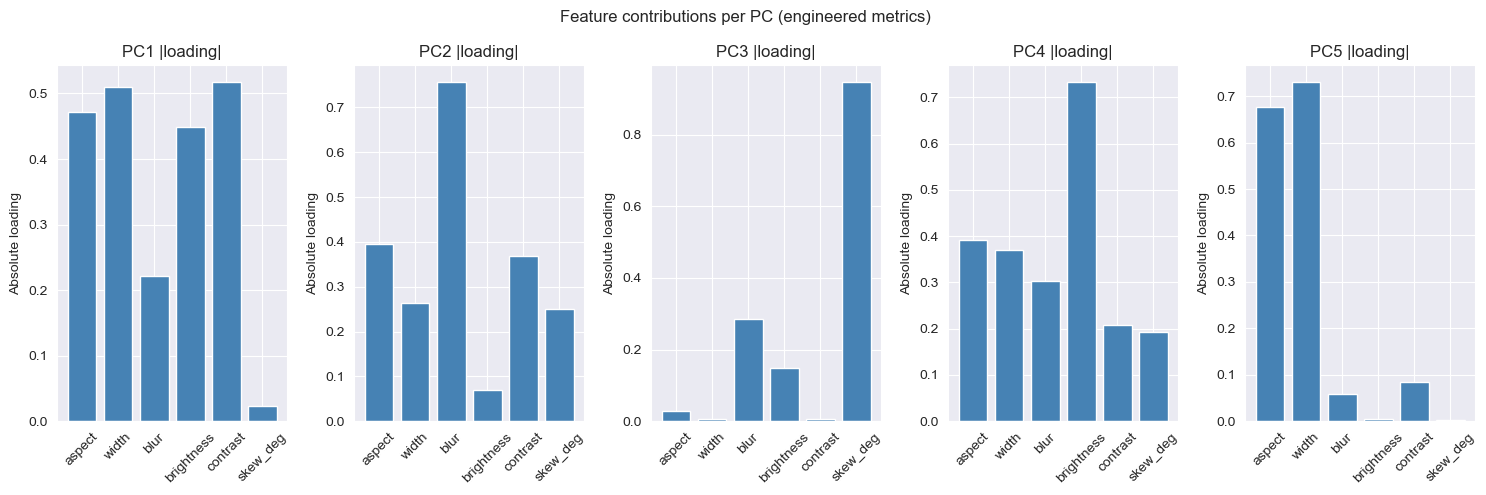

In [20]:
feat_candidates = ['aspect','width','blur','brightness','contrast','skew_deg']
feat_cols = [c for c in feat_candidates if 'img_df' in globals() and isinstance(img_df, pd.DataFrame) and c in img_df.columns]
if not feat_cols or len(feat_cols) < 2:
    print('Not enough engineered feature columns available for PCA barplots; need at least 2. Found:', feat_cols)
else:
    feats_df = img_df[feat_cols].dropna()
    if len(feats_df) < 2:
        print('Not enough rows after dropping NaNs for PCA barplots.')
    else:
        X_feat = feats_df.values
        # standardize features
        mu = X_feat.mean(axis=0)
        sigma = X_feat.std(axis=0, ddof=0)
        sigma[sigma == 0] = 1.0
        Xz = (X_feat - mu) / sigma
        n_comp_feat = min(5, Xz.shape[1], Xz.shape[0])
        try:
            from sklearn.decomposition import PCA as _PCA
            pca_feat = _PCA(n_components=n_comp_feat).fit(Xz)
            comps = pca_feat.components_
        except Exception:
            # Fallback via SVD if sklearn is unavailable
            U, S, Vt = np.linalg.svd(Xz, full_matrices=False)
            comps = Vt[:n_comp_feat, :]
        k = comps.shape[0]
        fig, axes = plt.subplots(1, k, figsize=(max(6, 3*k), max(3, 0.5*len(feat_cols)+2)))
        if k == 1:
            axes = [axes]
        for i in range(k):
            axes[i].bar(feat_cols, np.abs(comps[i]), color='steelblue', edgecolor='white')
            axes[i].set_title(f'PC{i+1} |loading|')
            axes[i].set_ylabel('Absolute loading')
            axes[i].tick_params(axis='x', rotation=45)
        plt.suptitle('Feature contributions per PC (engineered metrics)')
        plt.tight_layout()
        plt.show()

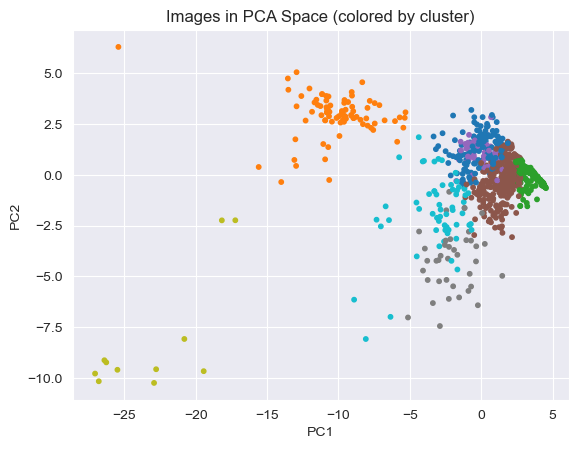

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='tab10', s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Images in PCA Space (colored by cluster)")
plt.show()

- The largest Principal Component PC1 is characterized mainly by aspect ratio, width, brightness, and contrast
- The second largest Principal Component PC2 (with almost the same weight as PC1) is characterized mainly by blur
- Most images in the dataset have somewhat high aspect ratio, width, brightness, and contrast and low blur by the clustering near (2,0)
- variance increases as PC1 becomes negative and as PC2 deviates from 0

## 4) Labels / Field Profiling


In [22]:
from dateutil import parser

labels = None

if LABELS_CSV:
    p = Path(LABELS_CSV)

    if p.exists():
        if p.is_dir():
            # Directory of per-image JSONs
            json_files = sorted(p.rglob('*.json'))
            if not json_files:
                print(f"No JSON files found in {p}")
            else:
                records = []
                for jf in json_files:
                    try:
                        data = json.load(open(jf, 'r', encoding='utf-8'))
                        # Only keep the expected fields
                        record = {
                            'company': data.get('company'),
                            'date': data.get('date'),
                            'address': data.get('address'),
                            'total': data.get('total'),
                            'json_path': str(jf)
                        }
                        records.append(record)
                    except Exception as e:
                        print(f"Failed to parse {jf}: {e}")

                labels = pd.DataFrame(records)

        elif p.is_file():
            # Single CSV file
            labels = pd.read_csv(p)

        # Clean 'total' column (remove $ and commas)
        if 'total' in labels.columns:
            labels['total'] = (
                labels['total']
                .astype(str)
                .str.replace(r'[\$,]', '', regex=True)
            )
            labels['total'] = pd.to_numeric(labels['total'], errors='coerce')

        # Parse 'date' column robustly
        if 'date' in labels.columns:
            def parse_date(x):
                try:
                    return parser.parse(str(x))
                except:
                    return pd.NaT
            labels['date_parsed'] = labels['date'].apply(parse_date)

        print("Labels loaded:", len(labels))
        display(labels.isna().mean().sort_values(ascending=False))
    else:
        print("LABELS_CSV path does not exist.")
else:
    print("LABELS_CSV not set.")

Labels loaded: 967


total          0.102378
date_parsed    0.002068
address        0.001034
company        0.000000
date           0.000000
json_path      0.000000
dtype: float64

In [23]:
labels_clean = labels.dropna(axis = 0, how = 'any')
display(labels_clean)

company        date  \
0                       OJC MARKETING SDN BHD  15/01/2019   
1                       OJC MARKETING SDN BHD  02/01/2019   
2                        PERNIAGAAN ZHENG HUI  09/02/2018   
3                        PETRON BKT LANJAN SB  01/02/2018   
4            GERBANG ALAF RESTAURANTS SDN BHD  18/01/2018   
..                                        ...         ...   
962  ONE ONE THREE SEAFOOD RESTAURANT SDN BHD  15-06-2018   
963  ONE ONE THREE SEAFOOD RESTAURANT SDN BHD  20-06-2018   
964  ONE ONE THREE SEAFOOD RESTAURANT SDN BHD  23-06-2018   
965                GL HANDICRAFT & TAIL ORING  20/03/2018   
966              LIAN HING STATIONERY SDN BHD  27/03/2018   

                                               address  total  \
0    NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B175...  193.0   
1    NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 8175...  170.0   
2    NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA...  436.2   
3    KM 458.4 BKT LANJAN UTARA, L/RAYA UTARA SELATA...    4.9   
4    LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, ...   38.9   
..                                                 ...    ...   
962  NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800...  148.5   
963  NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 4380...   38.0   
964  NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800...  179.5   
965  19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA ...  102.0   
966  NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SER...   12.0   

                   json_path date_parsed  
0    train_data/gdt/000.json  2019-01-15  
1    train_data/gdt/001.json  2019-02-01  
2    train_data/gdt/002.json  2018-09-02  
3    train_data/gdt/003.json  2018-01-02  
4    train_data/gdt/004.json  2018-01-18  
..                       ...         ...  
962  train_data/gdt/962.json  2018-06-15  
963  train_data/gdt/963.json  2018-06-20  
964  train_data/gdt/964.json  2018-06-23  
965  train_data/gdt/965.json  2018-03-20  
966  train_data/gdt/966.json  2018-03-27  

[867 rows x 6 columns]

<Axes: xlabel='total', ylabel='Count'>

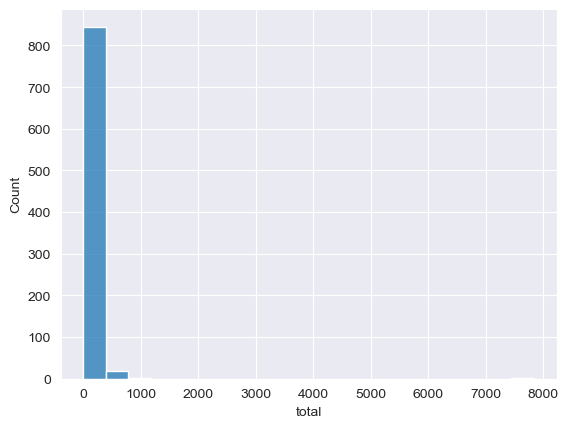

In [24]:
sns.histplot(labels_clean['total'], bins = 20)

<Axes: ylabel='Count'>

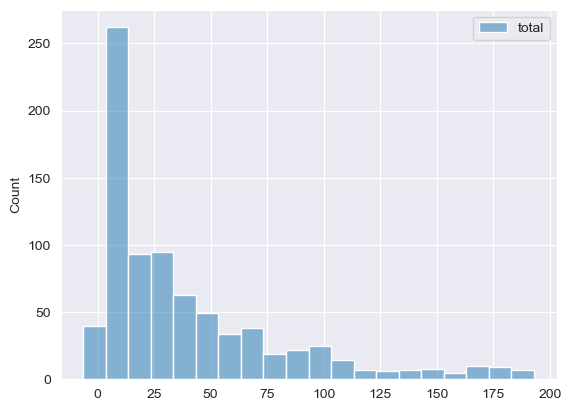

In [25]:
sns.histplot(labels_clean[ labels_clean['total'] < 200 ], bins = 20)

Most receipts are for relatively small purchases.

(NOTE) This dataset consists mostly of Malaysian receipts, so total values are most likely in RM, not USD.